### Feed-Forward Neural Network on CIFAR Data

First, import some libraries and some functions to get pretty looking plots

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Make matplotlib plot pretty pictures
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 14.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Reload external modules
%load_ext autoreload
%autoreload 2

### Neural Network Definition

A neural network class needs to have two functions - 

1. `__init__` : Here, you specify the size of the net, and the number and type of layers it has.
    * We have one hidden layer of size `hidden_size`, the `input_size` and the output size is `num_classes`.
    
2. `forward` : Define the forward propagation through your layers.
    
    * In the example below, there's a fully-connected layer -> RELU -> fully-connected layer -> output

In [2]:
# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

#### Hyperparameters

* `num_epochs` : The number of sweeps of your entire training data you wish to do.
* `batch_size` : The number of datapoints you take for each SGD step
* There could be other hyperparameters as well, such as learning rate decay.

In [6]:
# Hyper Parameters 
input_size = 32*32*3
hidden_size = 500
num_classes = 10
num_epochs = 10
batch_size = 100
learning_rate = 0.001

#### Working with the CIFAR10 Dataset

1. Download the data, and split it into training and test sets
2. Plot some images in the CIFAR10 set, to understand what we're dealing with.

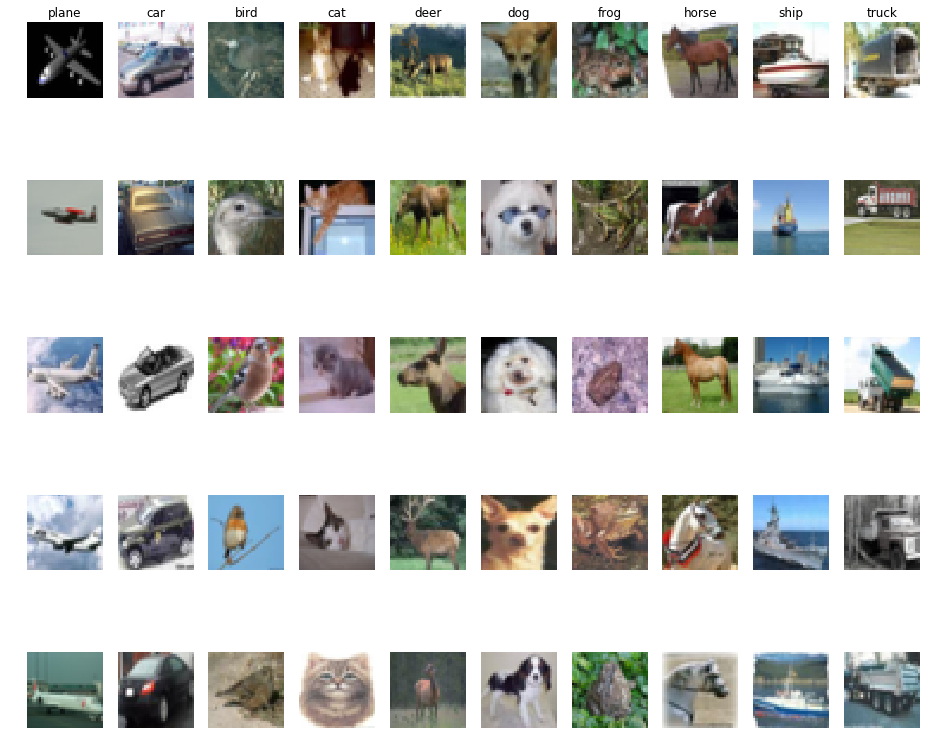

In [4]:
# CIFAR10 Dataset 
train_dataset = dsets.CIFAR10(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=False)

test_dataset = dsets.CIFAR10(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Explore the data
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# Explore the CIFAR Data
X_train = 255*np.moveaxis(images.numpy(), 1, -1)
y_train = labels.numpy()

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
	ids = np.flatnonzero(y_train == y)
	ids = np.random.choice(ids, samples_per_class, replace=False)

	for i, idxs in enumerate(ids):
		plt_idx = i*num_classes+y+1
		plt.subplot(samples_per_class, num_classes, plt_idx)
		plt.imshow(X_train[idxs].astype('uint8'))
		plt.axis('off')
		if i == 0:
			plt.title(cls)

plt.show()

In [5]:
# Initialize and train the neural network

net = Net(input_size, hidden_size, num_classes)
net.cuda()   # Tells PyTorch to use the GPU instead of the CPU 
    
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()   # This is softmax loss
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        images = Variable(images.view(-1, 32*32*3).cuda()) #.cuda() just tells Pytorch to shift everything to the GPU
        labels = Variable(labels.cuda())
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 32*32*3)).cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Model
torch.save(net.state_dict(), 'model.pkl')

Epoch [1/10], Step [100/500], Loss: 1.9003
Epoch [1/10], Step [200/500], Loss: 1.9519
Epoch [1/10], Step [300/500], Loss: 1.9599
Epoch [1/10], Step [400/500], Loss: 1.8986
Epoch [1/10], Step [500/500], Loss: 1.7666
Epoch [2/10], Step [100/500], Loss: 1.6355
Epoch [2/10], Step [200/500], Loss: 1.5740
Epoch [2/10], Step [300/500], Loss: 1.4288
Epoch [2/10], Step [400/500], Loss: 1.5055
Epoch [2/10], Step [500/500], Loss: 1.7811
Epoch [3/10], Step [100/500], Loss: 1.5916
Epoch [3/10], Step [200/500], Loss: 1.5448
Epoch [3/10], Step [300/500], Loss: 1.5582
Epoch [3/10], Step [400/500], Loss: 1.5978
Epoch [3/10], Step [500/500], Loss: 1.6088
Epoch [4/10], Step [100/500], Loss: 1.5835
Epoch [4/10], Step [200/500], Loss: 1.5791
Epoch [4/10], Step [300/500], Loss: 1.5455
Epoch [4/10], Step [400/500], Loss: 1.4734
Epoch [4/10], Step [500/500], Loss: 1.6181
Epoch [5/10], Step [100/500], Loss: 1.4618
Epoch [5/10], Step [200/500], Loss: 1.5809
Epoch [5/10], Step [300/500], Loss: 1.5155
Epoch [5/10